In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
from scipy.ndimage.measurements import label
import cv2
from util_functions import *
import glob
from collections import deque
from moviepy.editor import VideoFileClip
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

Not cars: 8968
Cars: 8790


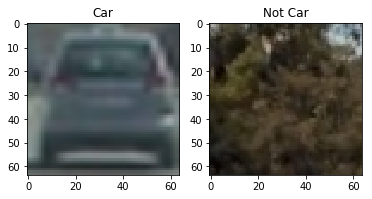

In [2]:

#from skimage.feature import hog
#from skimage import color, exposure
# images are divided up into vehicles and non-vehicles

notcars = glob.glob('./non-vehicles/*/*.png')

cars = glob.glob('./vehicles/*/*.png')


# for image in images:
#     if 'image' in image or 'extra' in image:
#         notcars.append(image)
#     else:
#         cars.append(image)
print("Not cars:",len(notcars))
print("Cars:",len(cars))

car_sample_img = mpimg.imread(cars[1])
not_car_sample_img = mpimg.imread(notcars[2])
plt.subplot(121)
plt.title("Car")
plt.imshow(car_sample_img)
plt.subplot(122)
plt.title("Not Car")
plt.imshow(not_car_sample_img)
plt.show()

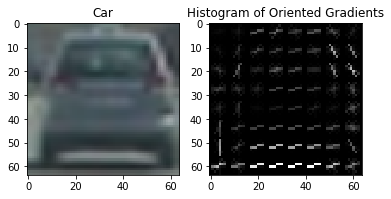

In [3]:

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 656] # Min and max in y to search in slide_window()
car_sample_img_yCrCb = cv2.cvtColor(car_sample_img, cv2.COLOR_RGB2YCrCb)
feats, hog_img = get_hog_features(car_sample_img_yCrCb[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

plt.subplot(121)
plt.title("Car")
plt.imshow(car_sample_img)
plt.subplot(122)
plt.title("Histogram of Oriented Gradients")
plt.imshow(hog_img, cmap="gray")
plt.show()

In [4]:
# def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
#                         hist_bins=32, orient=9, 
#                         pix_per_cell=8, cell_per_block=2, hog_channel=0,
#                         spatial_feat=True, hist_feat=True, hog_feat=True):
#     # Create a list to append feature vectors to
#     features = []
#     # Iterate through the list of images
#     for file in imgs:
#         file_features = []
#         # Read in each one by one
#         image = mpimg.imread(file)
#         # apply color conversion if other than 'RGB'
#         if color_space != 'RGB':
#             if color_space == 'HSV':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
#             elif color_space == 'LUV':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
#             elif color_space == 'HLS':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
#             elif color_space == 'YUV':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
#             elif color_space == 'YCrCb':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
#         else: feature_image = np.copy(image)      

#         if spatial_feat == True:
#             spatial_features = bin_spatial(feature_image, size=spatial_size)
#             file_features.append(spatial_features)
#         if hist_feat == True:
#             # Apply color_hist()
#             hist_features = color_hist(feature_image, nbins=hist_bins)
#             file_features.append(hist_features)
#         if hog_feat == True:
#         # Call get_hog_features() with vis=False, feature_vec=True
#             if hog_channel == 'ALL':
#                 hog_features = []
#                 for channel in range(feature_image.shape[2]):
#                     hog_features.append(get_hog_features(feature_image[:,:,channel], 
#                                         orient, pix_per_cell, cell_per_block, 
#                                         vis=False, feature_vec=True))
#                 hog_features = np.ravel(hog_features)        
#             else:
#                 hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
#                             pix_per_cell, cell_per_block, vis=False, feature_vec=True)
#             # Append the new feature vector to the features list
#             file_features.append(hog_features)
#         features.append(np.concatenate(file_features))
#     # Return list of feature vectors
#     return features

In [5]:
sample_size=5000
cars_sub = cars[:]
not_cars_sub = notcars[:]


car_features=extract_features(cars_sub, color_space=color_space,spatial_size=spatial_size,
                              hist_bins=hist_bins,orient=orient,pix_per_cell=pix_per_cell,cell_per_block=cell_per_block,
                              hog_channel=hog_channel,spatial_feat=spatial_feat,hist_feat=hist_feat,hog_feat=hog_feat)
notcar_features=extract_features(not_cars_sub, color_space=color_space, spatial_size=spatial_size,
                              hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                              hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


D:\tools\MiniConda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [6]:
print(len(X[0]))


6108


In [7]:


rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

In [8]:

parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svr = SVC()
clf = GridSearchCV(svr, parameters)
clf.fit(X_train, y_train)
svc = clf
# from sklearn.svm import LinearSVC
# svc = LinearSVC()
# svc.fit(X_train, y_train)

In [9]:
# def add_heat(heatmap, bbox_list):
#     # Iterate through list of bboxes
#     for box in bbox_list:
#         # Add += 1 for all pixels inside each bbox
#         # Assuming each "box" takes the form ((x1, y1), (x2, y2))
#         heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

#     # Return updated heatmap
#     return heatmap# Iterate through list of bboxes
    
# def apply_threshold(heatmap, threshold):
#     # Zero out pixels below the threshold
#     heatmap[heatmap <= threshold] = 0
#     # Return thresholded map
#     return heatmap

# def draw_labeled_bboxes(img, labels):
#     # Iterate through all detected cars
#     for car_number in range(1, labels[1]+1):
#         # Find pixels with each car_number label value
#         nonzero = (labels[0] == car_number).nonzero()
#         # Identify x and y values of those pixels
#         nonzeroy = np.array(nonzero[0])
#         nonzerox = np.array(nonzero[1])
#         # Define a bounding box based on min/max x and y
#         bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
#         # Draw the box on the image
#         cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
#     # Return the image
#     return img

In [18]:

def find_cars(img, ystart, ystop, scales, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,heat_threshold, recent_heats):
    draw_img = np.copy(img)
    img = img.astype(np.float32) / 255
    img_tosearch = img[ystart:ystop, :, :]
    boxes = []
    ctrans_img = convert_color(img_tosearch, conv='RGB2YCrCb')
    for scale in scales:
        if scale != 1:
            imshape = ctrans_img.shape
            ctrans_tosearch = cv2.resize(ctrans_img, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))
        else:
            ctrans_tosearch = ctrans_img

        ch1 = ctrans_tosearch[:, :, 0]
        ch2 = ctrans_tosearch[:, :, 1]
        ch3 = ctrans_tosearch[:, :, 2]

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
        nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1
        nfeat_per_block = orient * cell_per_block ** 2

        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1

        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb * cells_per_step
                xpos = xb * cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                hog_feat2 = hog2[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                hog_feat3 = hog3[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos * pix_per_cell
                ytop = ypos * pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop + window, xleft:xleft + window], (64, 64))

                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)

                # Scale features and make a prediction
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
                # test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))
                #test_features = X_scaler.transform(np.hstack(hog_features)).reshape(1, -1)
                test_prediction = svc.predict(test_features)
                if test_prediction == 1:
                    xbox_left = np.int(xleft * scale)
                    ytop_draw = np.int(ytop * scale)
                    win_draw = np.int(window * scale)
                    boxes.append(((xbox_left, ytop_draw + ystart),(xbox_left + win_draw, ytop_draw + win_draw + ystart)))
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,boxes)
    recent_heats.append(heat)
    heat = np.array(recent_heats).sum(axis=0)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,heat_threshold)
    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(draw_img, labels)
    
    return draw_img

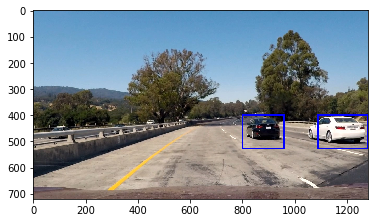

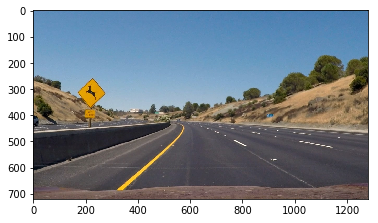

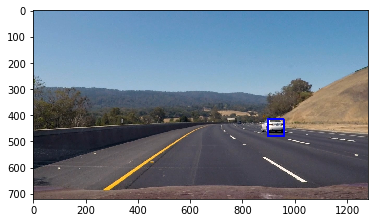

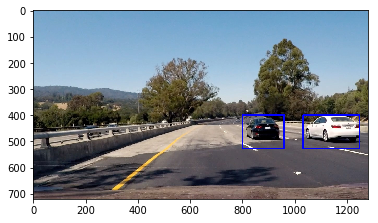

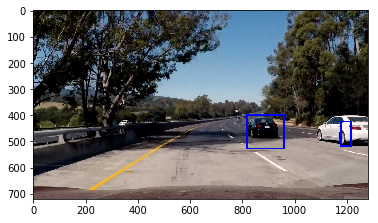

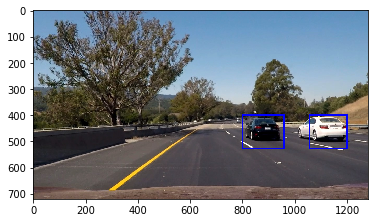

In [19]:

#print('My SVC predicts: ', svc.score(X_test,y_test))
test_images = glob.glob("test_images/*.jpg")
for file in test_images:
    img = mpimg.imread(file)
    recent_heats = deque(maxlen=10)
    heat_threshold = 1
    labels = [1.0,1.5,2.0,2.5]
    res = find_cars(img, y_start_stop[0], y_start_stop[1], labels, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,heat_threshold,recent_heats)
    plt.imshow(res)
    plt.show()
#res = find_cars(img, 400, None, 1.5, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
#plt.imshow(res)

In [5]:
def process_image(img):
    labels = [0.8,1.0,1.5,2.0,2.5]
    recent_heats = deque(maxlen=10)
    heat_threshold = 1
    res = find_cars(img, y_start_stop[0], y_start_stop[1], labels, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,heat_threshold,recent_heats)
    return res

In [7]:

vid_output = 'res_vid.mp4'
vid_in = VideoFileClip("project_video.mp4").subclip('00:00:18.00', '00:00:22.00')

# NOTE: this function expects color images


count = 1
def save_frames(img): 
    cv2.imwrite("./output_images/test/test"+str(count)+".jpg", cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    out = process_image(img)
    cv2.imwrite("./output_images/test/out"+str(count)+".jpg", cv2.cvtColor(out, cv2.COLOR_RGB2BGR))
    global count
    count= count+1
    return out

vid_out = vid_in.fl_image(process_image) 
vid_out.write_videofile(vid_output, audio=False)

vid_in.reader.close()
vid_in.audio.reader.close_proc()
vid_out.reader.close()
vid_out.audio.reader.close_proc()

[MoviePy] >>>> Building video res_vid.mp4
[MoviePy] Writing video res_vid.mp4


 99%|█████████████████████████████████████████████████████████████████████████████▏| 100/101 [1:47:26<01:03, 63.68s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: res_vid.mp4 



In [ ]:
# len(get_hog_features(car_sample_img[:,:,2], 
#                                         orient, pix_per_cell, cell_per_block, 
#                                         vis=False, feature_vec=True))

In [19]:
print(clf.score(X_test, y_test))

0.9954954954954955


In [18]:
#classifier_data = {'svc': svc, 'X_scaler': X_scaler, 'color_space': color_space, 'orient': orient,
#                    'pix_per_cell': pix_per_cell, 'cell_per_block': cell_per_block, 'hog_channel': hog_channel,
#                    'spatial_size': spatial_size, 'hist_bins': hist_bins, 'spatial_feat': spatial_feat,
#                    'hist_feat': hist_feat, 'hog_feat': hog_feat, 'y_start_stop': y_start_stop}

# Dump the dictionary to a pickle file for future use
#pickle.dump(classifier_data,open('classifier_data_backup.p', "wb")) 

In [6]:
classifier_data = pickle.load(open('classifier_data_backup.p', "rb"))
svc = classifier_data['svc']
X_scaler=classifier_data['X_scaler']
#svc.score(X_test, y_test)